In [261]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from plotting_utils import label_sample, figure_path
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from matplotlib import rcParams
from plotting_utils import rna_type_ce

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')


def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm


def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS|DNase',name):
            treatment = 'DNase I'
            is_long = 0
        elif re.search('[Pp]hos', name):
            treatment = 'DNase I + phosphatase'
            is_long = 0
            
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
count_file = project_path + '/Counts/all_counts/spreaded_all_counts.tsv'

count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type)) \
    .filter(regex=':dedup:sense|gene|grouped')\
    .assign(DNase_1 = lambda d: d.filter(regex='^Q[cC][fF][0-9]+').sum(axis=1))\
    .rename(columns = lambda x: x.split(':')[0])
count_df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf11_R1_001,Qcf4_R1_001,...,Qcf_LE1_R1_001,Qcf_NA2_R1_001,Qcf_NA3_R1_001,Qcf_NA4_R1_001,Qcf_Na1_R1_001,Qcf_Phos1_R1_001,S96-cfD_R1_001,S96-cf_R1_001,genome-sim_R1_001,DNase_1
0,.,.,No features,No features,19390,58098,76489,82382,71293,34993,...,42669,2087335,3562582,3714481,2292654,1628913,233495,262459,22673052,552483
1,.,No features:.,Repeats,Repeats,5368,15348,22911,16607,7629,6923,...,5833,1418768,2579012,2931394,1558777,1103819,88664,98991,16087246,109945
2,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,1592,98185,121277,57938,172233,137936,...,260,1608,1815,1725,1725,599579,61159,64303,269,1038722
3,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,2639,216448,240200,123083,374943,363327,...,1639,3304,4164,3791,3766,1513901,155182,162331,627,2413006
4,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,191,59402,49427,63388,159556,172616,...,406,226,491,491,273,204850,89781,92304,30,1028524


In [238]:
gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag[12]|FQ|DNa|Phos') \
    .query('grouped_type == "Protein coding"')\
    .assign(id = lambda d: d.gene_id.str.split('.', expand=True).iloc[:,0])\
    .drop('gene_id', axis=1)\
    .merge(gene_length)  
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.head()

,gene_name,gene_type,grouped_type,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_Phos1_R1_001,DNase_1,id,glength
0,TSPAN6,protein_coding,Protein coding,28.687760,9.374456,0.721604,0.000000,11.712779,2,ENSG00000000003,11321
1,TNMD,protein_coding,Protein coding,11.962479,14.072560,0.541622,0.708069,14.652298,1,ENSG00000000005,15083
2,DPM1,protein_coding,Protein coding,9.140328,2.240126,2.414090,0.225426,8.396680,2,ENSG00000000419,23688
3,SCYL3,protein_coding,Protein coding,12.126763,1.188819,0.183020,0.000000,12.873053,3,ENSG00000000457,44636
4,C1orf112,protein_coding,Protein coding,8.646688,6.081022,4.851117,0.806648,6.792014,3,ENSG00000000460,191976


In [239]:
def read_platelet():
    d = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/platelets/platelet/quant.genes.sf'
    return pd.read_table(d) \
        .filter(['Name','TPM'])\
        .rename(columns = {"Name":'Gene',
                          'TPM':'platelet'}) \
        .assign(Gene = lambda d: d.Gene.str.split('.',expand=True).iloc[:, 0])

gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr) \
    .pipe(pd.pivot_table, index=['Gene','Gene name'],columns="Sample", values='Value')\
    .merge(read_platelet(), on = 'Gene') \
    .pipe(pd.melt, id_vars = 'Gene', var_name = 'Sample', value_name = 'Value')
expr_df.head()

,Gene,Sample,Value
0,ENSG00000000003,adipose tissue,31.5
1,ENSG00000000005,adipose tissue,10.1
2,ENSG00000000419,adipose tissue,45.6
3,ENSG00000000457,adipose tissue,5.7
4,ENSG00000000460,adipose tissue,2.0


In [240]:
top_n = 80
tpm_cor_df = tpm_df\
    .filter(regex='id|Frag|L[12]')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .iloc[:, 1:]\
    .transform(lambda x: np.log(x+1))\
    .corr(method = 'pearson')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,
bone marrow,bone marrow,0.094033,0.120003,0.521288,0.534102
spleen,spleen,0.092381,0.119413,0.479885,0.483267
lymph node,lymph node,0.071285,0.101848,0.479171,0.483644
appendix,appendix,0.092297,0.122381,0.475214,0.478529
platelet,platelet,0.176664,0.179591,0.472091,0.481157
tonsil,tonsil,0.059349,0.093622,0.464226,0.466403
salivary gland,salivary gland,0.128913,0.143020,0.456827,0.472881
adipose tissue,adipose tissue,0.100529,0.126138,0.449651,0.454173
colon,colon,0.086365,0.114723,0.447026,0.457876


In [241]:
def plot_heatmap_tissue(cor_df, regex='L[12]', figurename = None):
    fig = plt.figure(figsize = (10,3))
    ax = fig.add_subplot(111)
    plot_df = cor_df.filter(regex = regex)\
                .pipe(lambda d: d.sort_values(d.columns[-1], ascending=False))\
                .rename(columns = rename_longRNA)\
                .transpose()
    sns.heatmap(plot_df,
           cmap = 'viridis', ax = ax)
    ax.set_ylabel('Sample')
    ax.set_xlabel('Primary tissue')
    xt = ax.set_xticks(np.arange(plot_df.shape[1])+0.5)
    xt = ax.set_xticklabels(plot_df.columns.str.capitalize(), fontsize=14, 
                        rotation=70, rotation_mode='anchor', ha ='right')
    for xt in ax.get_xticklabels():
        if re.search('one marrow|ymph node|pleen|latelet', xt.get_text()):
            xt.set_color('#72624a')
        else:
            xt.set_color('#adaba9')
        xt.set_text(xt.get_text().capitalize())
    fig.text(0.86,0.7, r"Spearman's $\rho$", rotation = 270, fontsize=15)
    fig.savefig(figurename, bbox_inches='tight')
    print('Saved:', figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/tissue_heatmap.pdf


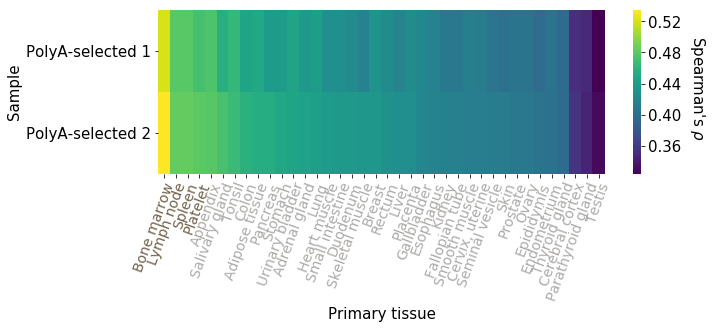

In [242]:
figurename = figure_path + '/tissue_heatmap.pdf'
plot_heatmap_tissue(cor_df, regex='L[12]', figurename = figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/tissue_heatmap_frag.pdf


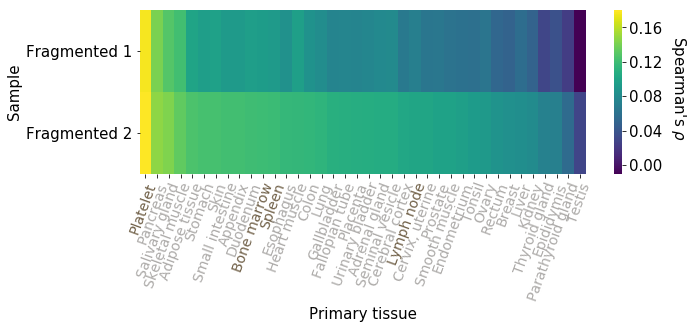

In [243]:
figurename = figure_path + '/tissue_heatmap_frag.pdf'
plot_heatmap_tissue(cor_df, regex='Frag', figurename = figurename)

In [244]:
colors = ['red','darkgreen','chocolate','purple4','gold','khaki',
          'brown','pink','steelblue','skyblue','darkgrey']
tissues_order = ["Abdominal" ,'Brain',"Breast/Female Reproductive","Lung","Lymphoid", 
                 "Myeloid","Sarcoma", "Skin", "Urinary/Male Reproductive" ,
                 "Primary Tissue",'Other']

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


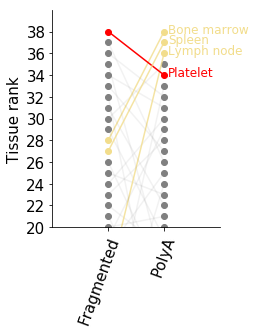

In [245]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
for tissue, row in cor_df \
        .filter(regex='Frag2|L1') \
        .reset_index()\
        .pipe(pd.melt, id_vars = 'index') \
        .assign(x = lambda d: np.where(d.variable.str.contains('Frag'), 1, 2))\
        .assign(rank = lambda d: d.groupby(['x','variable'])['value'].rank(ascending=True))\
        .pipe(pd.pivot_table, columns='variable', values='rank', index='index')\
        .iterrows():
    color = 'gray'
    alpha = 0.1
    if re.search('bone marrow|lymph node|spleen', tissue):
        color = '#f2dd8c'
        alpha = 0.8
    elif re.search('platelet', tissue):
        color = 'red'
        alpha = 1
        
    if color != "gray":
        ax.text(2+0.07, row['Qcf_L1_R1_001']-0.1, tissue.capitalize(), ha = 'left',
                color = color, size = 12)
    ax.scatter([1,2], 
             [row['Qcf_Frag2_R1_001'], row['Qcf_L1_R1_001']], 
            color=color, alpha=1)
    ax.plot([1,2], 
             [row['Qcf_Frag2_R1_001'], row['Qcf_L1_R1_001']], 
            color=color, alpha=alpha)
ax.set_ylabel('Tissue rank')
ax.set_xlim(0,3)
ax.set_xticks([1,2])
ax.set_xticklabels(['Fragmented','PolyA'], 
                   rotation=70, ha = 'right', rotation_mode='anchor')
ax.set_ylim(20,40)
ax.set_yticks(range(20,40,2))
ax.set_yticklabels(range(20,40,2))
ax.set_xlabel('')
sns.despine()
fig.savefig(figure_path + '/correlation_change.pdf',
           bbox_inches='tight')

In [246]:
def plot_heatmap(ax, sort_column, ylab=False):
    top_n = 50
    hd = tpm_df\
        .query('gene_type == "protein_coding"')\
        .pipe(lambda d: d[~d.gene_name.str.contains('^MT')]) \
        .set_index('gene_name') \
        .rename(columns = rename_longRNA) \
        .filter(regex = 'Poly|Frag|DN|Phos')\
        .nlargest(top_n, sort_column) \
        .transform(lambda x: np.log2(x + 1))

    sns.heatmap(hd, cmap='viridis', ax = ax)
    yt = ax.set_yticks(np.arange(top_n) +0.5)
    yt = ax.set_yticklabels(hd.index[:top_n], fontsize = 12)
    if ylab:
        ax.set_ylabel('Protein-coding genes')
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation = 70,
                       ha='right',
                       rotation_mode = 'anchor')

    for xt in ax.get_xticklabels():
        if xt.get_text() == sort_column:
            xt.set_color('red')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/protein_heatmap.pdf


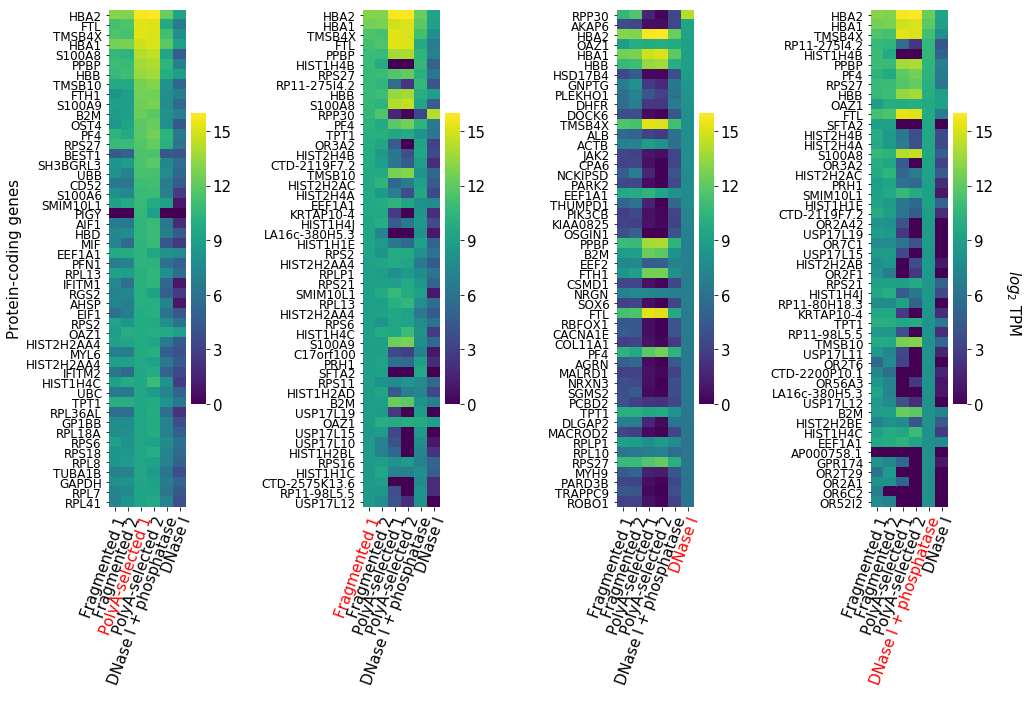

In [247]:
fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)



plot_heatmap(ax, 'PolyA-selected 1', ylab=True)
plot_heatmap(ax2, 'Fragmented 1')
plot_heatmap(ax3, 'DNase I')
plot_heatmap(ax4, 'DNase I + phosphatase')
fig.tight_layout()
fig.text(1,0.6, r"$log_2$ TPM", rotation = 270, fontsize=15)
figure_name = figure_path + '/protein_heatmap.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved %s' %figure_name)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/all_long_rna.pdf


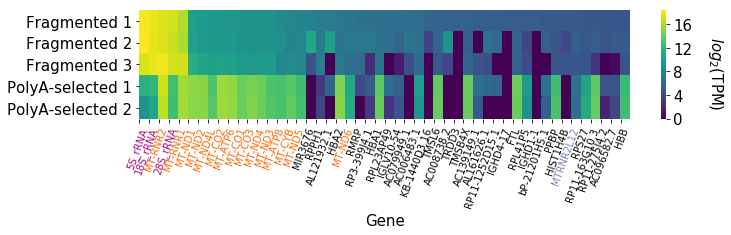

In [251]:
top_n = 50

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ|DNa') \
    .pipe(lambda d: d[~d.grouped_type.str.contains('tRNA|snRNA|snoRNA|snc')])\
    .pipe(lambda d: d[~d.gene_name.str.contains('RNU')])\
    .assign(id = lambda d: d.gene_id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)  
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])

all_heat_df = tpm_df\
    .nlargest(top_n,'Qcf_Frag1_R1_001')\
    .set_index('gene_name')\
    .filter(regex = 'Qc') \
    .transform(lambda x: np.log2(x+1))\
    .rename(columns = rename_longRNA)\
    .transpose() 

fig = plt.figure(figsize = (11,2))
ax = fig.add_subplot(111)
sns.heatmap(all_heat_df, ax = ax, 
            cmap = 'viridis')
ax.set_xticks(np.arange(top_n))
xt = ax.set_xticklabels(all_heat_df.columns, rotation = 70,
                   fontsize=10, rotation_mode = 'anchor', ha = 'right')
for xt in ax.get_xticklabels():
    if 'MTRNR2L' in xt.get_text():
        xt.set_color('#7a84ba')
    elif 'MT' in xt.get_text():
        xt.set_color('#ff6600')
    elif 'rRNA' in xt.get_text():
        xt.set_color('#aa0b7b')
ax.set_xlabel('Gene')
fig.text(0.84, 0.6, '$log_2$(TPM)', rotation = 270, fontsize=15)
figurename = figure_path + '/all_long_rna.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

In [252]:
def plot_quantile_group(ax, qcut_expr_df):
    colors = simpsons_palette()
    for col, (gl, gl_df) in zip(colors, qcut_expr_df.groupby('ntile')):
        sns.distplot(np.log2(gl_df.glength), 
                 ax = ax, 
                 color = col,
                 label = gl,
                hist=False)
    ax.set_xlabel('Gene length')
    ax.set_ylabel('Density')
    ax.legend(fontsize=15, frameon=False).set_visible(False)
    sns.despine()
    
    
def plot_cor_quantile(ax, expr_df, tpm_df):
    qcut_expr_df = expr_df\
        .pipe(pd.pivot_table, columns = 'Sample', 
              index=['Gene'], values='Value') \
        .reset_index() \
        .merge(tpm_df.rename(columns = {'id':'Gene'}), 
                on ='Gene', how ='inner') \
        .filter(regex = 'name|glength|Gene|L1|bone marrow') \
        .assign(ntile = lambda d: pd.qcut(d.glength, 10, labels=False))\
        .assign(ntile = lambda d: d.ntile.astype(str))
    
    qcut_expr_df.filter(regex = 'ntile|bone|Qc')\
        .reset_index()\
        .groupby('ntile', as_index=False)\
        .apply(cor_ntile) \
        .set_index('ntile')\
        .transpose()\
        .plot.bar( ax = ax, colors = simpsons_palette())
    lgd = ax.legend(bbox_to_anchor = (1,1), title='Quantile\ngene\ngroup', 
                    frameon=False, fontsize=15)
    lgd =plt.setp(lgd.get_title(),fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation =70, rotation_mode = 'anchor', ha = 'right')
    ax.set_xlabel('Distance function')
    ax.set_ylabel(r"Coefficient"\
              ' between\nBone marrow (published) and\nPlasma (polyA-selected)')
    sns.despine()
    return qcut_expr_df
        
        
def cor_ntile(d):
    x = np.log(d['bone marrow']+1)
    y = np.log(d['Qcf_L1_R1_001']+1)
    spearman_r, _ = spearmanr(x, y)
    pearson_r, _ = pearsonr(x, y)
    cosine_sim = cosine_similarity(x.values.reshape(1,-1), y.values.reshape(1,-1))
    #cor_coef = d.filter(regex = 'bone|Qc').corr(method='spearman')
    #cor_coef = cor_coef.iloc[0,1]
    return pd.DataFrame({'ntile':[d.ntile.unique()[0]],
                        "Spearman's\ncorrelation":[spearman_r],
                         "Pearson's\ncorrelation":[pearson_r],
                        'Cosine\nsimilarity':[cosine_sim[0][0]]})

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/quantile_plot.pdf


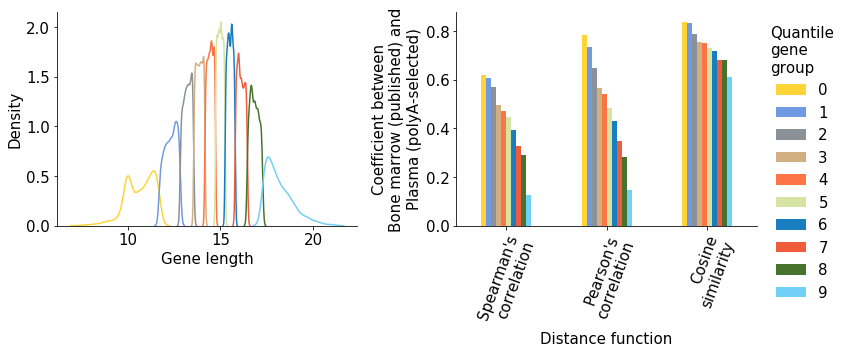

In [253]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(122)
qcut_expr_df = plot_cor_quantile(ax, expr_df, tpm_df)

ax=fig.add_subplot(121)
plot_quantile_group(ax, qcut_expr_df)
fig.tight_layout()
figurename = figure_path + '/quantile_plot.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/scatter_cosine.png


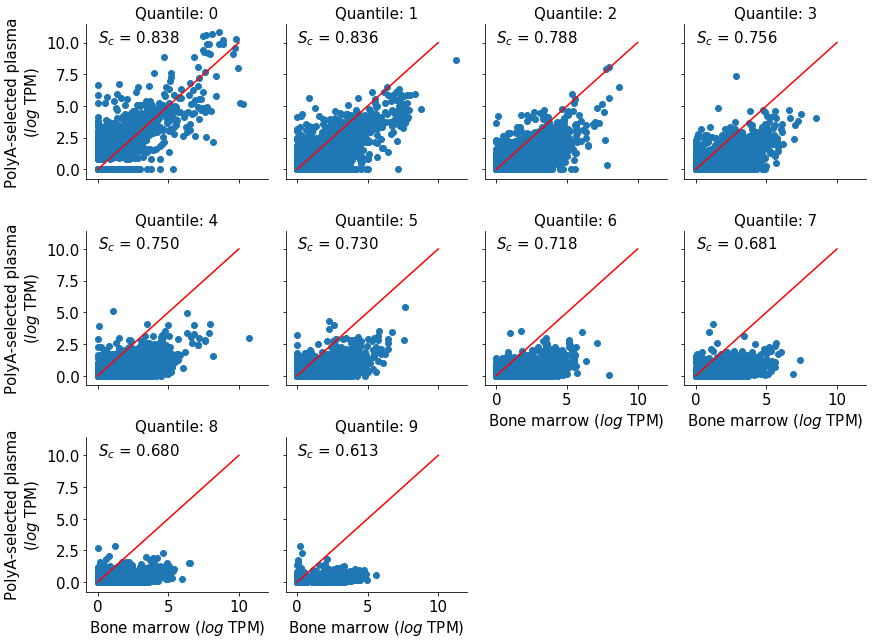

In [254]:
from scipy.stats import pearsonr

plot_qcut = qcut_expr_df\
            .assign(plasma = lambda d: d['Qcf_L1_R1_001'].transform(lambda x: np.log(x+1)))\
            .assign(bone = lambda d: d['bone marrow'].transform(lambda x: np.log(x+1)))\
            .sort_values('ntile')
p = sns.FacetGrid(data = plot_qcut, 
                  col = 'ntile', col_wrap = 4)
p.map(plt.scatter, 'bone', 'plasma')
p.set_titles('Quantile: {col_name}')
p.set_axis_labels('Bone marrow ($log$ TPM)', 'PolyA-selected plasma\n($log$ TPM)')

for ax in p.fig.axes:
    ax.plot([0,10],[0,10], color='red')
    
    data = plot_qcut.query("ntile == '%s'" %(ax.title.get_text().split(' ')[1]))
    cor_coef = cosine_similarity(data['plasma'].values.reshape(1,-1), 
                                       data['bone'].values.reshape(1,-1))
    ax.text(0, 10, r'$S_c$ = %.3f' %cor_coef, fontsize=15)
    
    
figurename = figure_path + '/scatter_cosine.png'
p.savefig(figurename, bbox_inches = 'tight')
print('Saved:', figurename)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


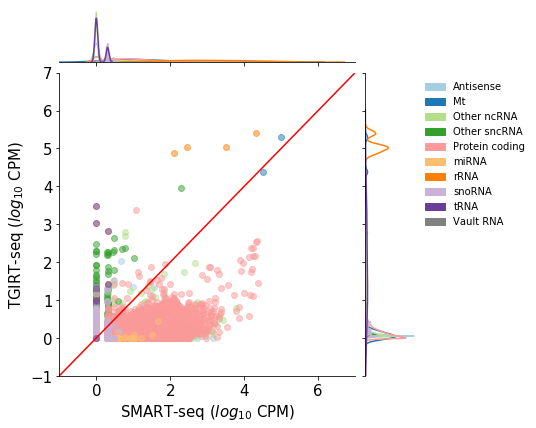

In [263]:
scatter_df = count_df\
    .filter(regex='id|type|name|[Qq][cC][fF][0-9]+|L[12]') \
    .pipe(lambda d: d[~d.grouped_type.str.contains('Repeats|features')])\
    .pipe(pd.melt, id_vars = ['gene_id','grouped_type','gene_type','gene_name']) \
    .assign(prep = lambda d: np.where(d.variable.str.contains('L[12]'), 'SMART-seq','TGIRT')) \
    .assign(value = lambda d: d.groupby('variable')['value'].transform(lambda x: 1e6 * x/x.sum()))\
    .groupby(['gene_id','grouped_type','gene_type','gene_name', 'prep'], as_index=False)\
    .agg({'value':'mean'}) \
    .assign(value = lambda d: np.log10(d['value']+1))\
    .pipe(pd.pivot_table, index=['gene_id','grouped_type','gene_type','gene_name'],
         columns = 'prep', values = 'value', fill_value=0) \
    .reset_index()\
    .assign(color = lambda d: d.grouped_type.map(rna_type_ce.encoder))

p = sns.JointGrid(data = scatter_df, 
                  x = 'SMART-seq', 
                  y = 'TGIRT')    
for (gt, col), gt_df in scatter_df.groupby(['grouped_type','color']):
    p.ax_joint.scatter(gt_df['SMART-seq'], 
                       gt_df['TGIRT'], 
                       color = col, alpha=0.5)
    sns.distplot(gt_df['SMART-seq'], ax = p.ax_marg_x, color = col, hist=False)
    sns.distplot(gt_df['TGIRT'], ax = p.ax_marg_y, color = col, hist=False, vertical=True)
    p.ax_marg_x.set_xlabel('')
    p.ax_marg_y.set_ylabel('')

try:
    del rna_type_ce.encoder['No features']
    del rna_type_ce.encoder['Repeats']
except KeyError:
    pass

rna_type_ce.show_legend(p.ax_marg_y, bbox_to_anchor = (1,1), frameon=False)
p.set_axis_labels('SMART-seq ($log_{10}$ CPM)', 'TGIRT-seq ($log_{10}$ CPM)')


min_v, max_v = -1, 7
p.ax_marg_y.set_ylim(min_v, max_v)
p.ax_marg_x.set_xlim(min_v,max_v)
p.ax_joint.set_xlim(min_v, max_v)
p.ax_joint.set_ylim(min_v, max_v)
p.ax_joint.plot([min_v, max_v],[min_v,max_v], color='red')
p.savefig(figure_path + '/gene_scatter.pdf', bbox_inches='tight')

In [337]:
exon_df =pd.read_table('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/exons/exon_table.tsv',
                        names = ['gene_name','transcript','exon_1_count', 'transcript_coverage', 
                                 'number_of_exon','samplename']) \
    .assign(exon_label = lambda d: np.where(d.number_of_exon > 10, '>10 exon', '<=10 exon'))
exon_df.head()

,gene_name,transcript,exon_1_count,transcript_coverage,number_of_exon,samplename,exon_label
0,SDF4,ENST00000263741,0,8,7,Qcf11_R1_001,<=10 exon
1,B3GALT6,ENST00000379198,5,5,1,Qcf11_R1_001,<=10 exon
2,GNB1,ENST00000610897,0,4,11,Qcf11_R1_001,>10 exon
3,SKI,ENST00000378536,2,5,7,Qcf11_R1_001,<=10 exon
4,SKI,ENST00000507179,0,3,2,Qcf11_R1_001,<=10 exon


In [375]:
pt_exon_df = exon_df \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .query('number_of_exon > 1 & transcript_coverage > 10')\
    .groupby(['gene_name','prep','exon_label','transcript', 'number_of_exon'], as_index=False)\
    .agg({'exon_1_count':'sum',
         'transcript_coverage':'sum'}) \
    .assign(exon1 = lambda d: d.exon_1_count/d.transcript_coverage) \
    .pipe(pd.pivot_table, columns = 'prep', values='exon1', 
          index=['transcript','gene_name', 'exon_label', 'number_of_exon'], 
          fill_value = 0)\
    .pipe(lambda d: d[d.min(axis=1)>0]) \
    .reset_index()
pt_exon_df.head()

prep,transcript,gene_name,exon_label,number_of_exon,DNase I,PolyA-selected
0,ENST00000202773,RPL6,<=10 exon,7,0.068966,0.004394
1,ENST00000223423,PTGS1,>10 exon,11,0.437500,0.023810
2,ENST00000224237,VIM,<=10 exon,9,0.133333,0.072682
3,ENST00000225430,RPL19,<=10 exon,6,0.250000,0.027477
4,ENST00000225655,PFN1,<=10 exon,3,1.000000,0.265244


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


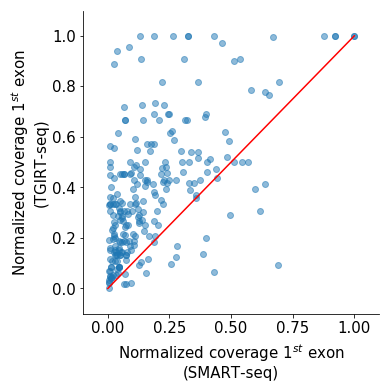

In [376]:
p = sns.JointGrid(data = pt_exon_df, 
                  x = 'PolyA-selected', y = 'DNase I',
                 xlim = [-0.1,1.1], ylim = [-0.1,1.1])
p.plot_joint(plt.scatter,alpha=0.5)
p.plot_marginals(sns.distplot, hist=False)

p.ax_joint.plot([0,1],[0,1], color = 'red')
p.ax_marg_x.set_visible(False)
p.ax_marg_y.set_visible(False)

p.set_axis_labels('Normalized coverage 1$^{st}$ exon\n(SMART-seq)',
                 'Normalized coverage 1$^{st}$ exon\n(TGIRT-seq)')
p.savefig(figure_path + '/exon1.png')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


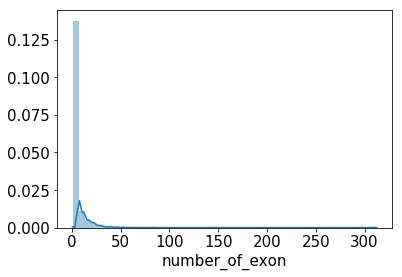

In [336]:
sns.distplot(exon_df.number_of_exon)